In [1]:
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
import regex
import string
import re
import nltk
import missingno as msno
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#sklearn.model_selection
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

# Read Datasets 

In [26]:
auto_ind = pd.read_csv('train/automobile_industry.csv')
comp_ind = pd.read_csv('train/computer_industry.csv')
health_ind = pd.read_csv('train/health_industry.csv')
manu_ind = pd.read_csv('train/manufacturing_industry.csv')
power_ind = pd.read_csv('train/power_industry.csv')

test = pd.read_csv('test/test.csv')
#Add Industry Identifier
auto_ind['Industry']='Automobile'
comp_ind['Industry']='Computer'
health_ind['Industry']='Health'
manu_ind['Industry']='Manufacturing'
power_ind['Industry']='Power'

In [ ]:
msno.bar(auto_ind)

# Read Product Info

In [ ]:
arr = os.listdir('train/product_info')
strtxt = ".txt"
all_product_info = pd.DataFrame()
for txtfile in arr:
    if txtfile.__contains__(strtxt):
        file_add = str('train/product_info/')+str(txtfile)
        fileObject = open(file_add, "r", encoding="unicode_escape")
        data = fileObject.read()
        product_info_data = pd.DataFrame([[txtfile.replace(strtxt,'') ,data]],columns = ['ID','product_info'])
        all_product_info = all_product_info.append(product_info_data)

# Merge Product Info with Training Data
auto_ind = auto_ind.merge(all_product_info, on='ID', how='left')
comp_ind = comp_ind.merge(all_product_info, on='ID', how='left')
health_ind = health_ind.merge(all_product_info, on='ID', how='left')
manu_ind = manu_ind.merge(all_product_info, on='ID', how='left')
power_ind = power_ind.merge(all_product_info, on='ID', how='left')


# Handle Nulls and Missing Values and define Dependent & Independent variables

In [3]:
id_columns = ['ID']
x_columns = ['Company_background']
y_columns = ['Industry','Type','Product']
def fix_type(df):
    df = df.fillna('')
    df = df.replace('?','')
    df['Type'] = df['Type'].str.replace('vehicle','Vehicles')
    y_combs = df[y_columns].drop_duplicates()
    y_combs['y_identifier']=np.arange(0,len(y_combs))
    df = df.merge(y_combs, on = y_columns,how='inner')
    y_dist = pd.DataFrame({'row_count': df.groupby(y_columns)['Company_background'].count()}).reset_index()
    imputed_type_combination = y_dist.groupby('Product')['row_count'].max().reset_index()
    imputed_type_combination = imputed_type_combination.merge(y_dist, on = ['Product','row_count'],how='inner').reset_index(drop = True)
    imputed_type_combination = imputed_type_combination.reindex(columns = ['Industry','Type','Product','row_count'])
    final_y_combinations = y_combs.drop('Type',axis =1).merge(imputed_type_combination,on = ['Industry','Product'],how = 'left')
    final_y_combinations = final_y_combinations.reindex(columns = ['Industry','Type','Product','y_identifier'])
    df = df.drop(y_columns,axis=1)
    df = df.merge(final_y_combinations, on ='y_identifier',how='inner')
    return df

auto_ind_imp_type = fix_type(auto_ind)
comp_ind_imp_type = fix_type(comp_ind)
health_ind_imp_type = fix_type(health_ind)
manu_ind_imp_type = fix_type(manu_ind)
power_ind_imp_type = fix_type(power_ind)
input_df = pd.concat([auto_ind_imp_type,comp_ind_imp_type,health_ind_imp_type,manu_ind_imp_type,power_ind_imp_type])

# NlP Processing for Text Columns

In [4]:
porter = PorterStemmer()
table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#define NLP Functions
def cleantext(val):
    val = str(val).replace(r'[^\x00-\x7F]+', '')
    if len(val.split()) >=2:
        val = val.lower()
        tk = word_tokenize(val)
        #tk = [porter.stem(word) for word in tk]
        #tk = [lemmatizer.lemmatize(word) for word in tk]
        #tk = [w.translate(table) for w in tk]
        tk = [word for word in tk if word.isalpha()]
        tk = [w for w in tk if not w in stop_words]
        return ' '.join(tk)
    else:
        return 'Not Avaiable'

def preprocess_dataframe(input_df,x_columns,y_columns=None):

    if(y_columns==None):
        df = input_df.drop(x_columns,axis=1) 
    else:
        df = input_df.reindex(columns = y_columns)
    
    df['text'] = input_df[x_columns].apply(lambda x: ' '.join(x.map(str)), axis=1)
    df['text']= df['text'].apply(lambda x: x.lower())
    df['clean'] = df['text'].apply(cleantext)
    df = df.dropna(axis=0, subset=['clean'])
    return df

# Call PreProcess & NLP Functions

In [ ]:
auto_processed = preprocess_dataframe(auto_ind_imp_type,x_columns,y_columns)
comp_processed = preprocess_dataframe(comp_ind_imp_type,x_columns,y_columns)
health_processed = preprocess_dataframe(health_ind_imp_type,x_columns,y_columns)
manu_processed = preprocess_dataframe(manu_ind_imp_type,x_columns,y_columns)
power_processed = preprocess_dataframe(power_ind_imp_type,x_columns,y_columns)
input_df_processed = pd.concat([auto_processed,comp_processed,health_processed,manu_processed,power_processed])
test_processed - preprocess_dataframe(test,x_columns,y_columns)

# Feature Engineering

In [ ]:

def create_word_industry_feature_mapp(df,var,n_range):
    vectorizer = TfidfVectorizer(min_df=2,ngram_range = (1,n_range),lowercase = True) #ngram_range=(1,2)
    distinct_vars = list(df[var].drop_duplicates())
    j=0
    
    for i in distinct_vars:
        df_name = 'df'+'_'+i
        new_col_name = str(var)+'_'+str(i)
        globals()[df_name] = df[df[var]==i]
        vectorizer.fit(globals()[df_name]['clean'].apply(lambda x: np.str_(x)))
        globals()[df_name+'_list'] = set(vectorizer.get_feature_names())
        globals()[df_name+'_list_df'] = pd.DataFrame(globals()[df_name+'_list'],columns = ['words'])
        globals()[df_name+'_list_df'][new_col_name] = i
        if(j==0):
            distinct_words =  globals()[df_name+'_list']
        else:
            distinct_words = distinct_words ^ globals()[df_name+'_list']  
        j=j+1
    
    distinct_words_df = pd.DataFrame(distinct_words,columns = ['words'])
    for i in distinct_vars:
        df_name = 'df'+'_'+i
        distinct_words_df = distinct_words_df.merge(globals()[df_name+'_list_df'],on = 'words',how= 'left')
    
    
    distinct_words_df['null_count'] = distinct_words_df.isnull().sum(axis =1)
    if (var == 'Industry'):
        distinct_words_df = distinct_words_df[distinct_words_df['null_count']==4]
        distinct_words_df['Feature'] = np.nan
        distinct_words_df['Feature'] = distinct_words_df['Feature'].fillna(distinct_words_df.iloc[:,1]).fillna(distinct_words_df.iloc[:,2]).fillna(distinct_words_df.iloc[:,3]).fillna(distinct_words_df.iloc[:,4]).fillna(distinct_words_df.iloc[:,5])
        distinct_words_df = distinct_words_df.reindex(columns = ['words','Feature']) 
    elif(var == 'Type'):
        distinct_words_df = distinct_words_df[distinct_words_df['null_count']==11]
        distinct_words_df['Feature'] = np.nan
        distinct_words_df['Feature'] = distinct_words_df['Feature'].fillna(distinct_words_df.iloc[:,1]).fillna(distinct_words_df.iloc[:,2]).fillna(distinct_words_df.iloc[:,3]).fillna(distinct_words_df.iloc[:,4]).fillna(distinct_words_df.iloc[:,5]).fillna(distinct_words_df.iloc[:,6]).fillna(distinct_words_df.iloc[:,7]).fillna(distinct_words_df.iloc[:,8]).fillna(distinct_words_df.iloc[:,9]).fillna(distinct_words_df.iloc[:,10]).fillna(distinct_words_df.iloc[:,11]).fillna(distinct_words_df.iloc[:,12])
        distinct_words_df = distinct_words_df.reindex(columns = ['words','Feature']) 
    elif(var == 'Product'):
        distinct_words_df = distinct_words_df[distinct_words_df['null_count']==24]
        distinct_words_df['Feature'] = np.nan
        distinct_words_df['Feature'] = distinct_words_df['Feature'].fillna(distinct_words_df.iloc[:,1]).fillna(distinct_words_df.iloc[:,2]).fillna(distinct_words_df.iloc[:,3]).fillna(distinct_words_df.iloc[:,4]).fillna(distinct_words_df.iloc[:,5]).fillna(distinct_words_df.iloc[:,6]).fillna(distinct_words_df.iloc[:,7]).fillna(distinct_words_df.iloc[:,8]).fillna(distinct_words_df.iloc[:,9]).fillna(distinct_words_df.iloc[:,10]).fillna(distinct_words_df.iloc[:,11]).fillna(distinct_words_df.iloc[:,12]).fillna(distinct_words_df.iloc[:,13]).fillna(distinct_words_df.iloc[:,14]).fillna(distinct_words_df.iloc[:,15]).fillna(distinct_words_df.iloc[:,16]).fillna(distinct_words_df.iloc[:,17]).fillna(distinct_words_df.iloc[:,18]).fillna(distinct_words_df.iloc[:,19]).fillna(distinct_words_df.iloc[:,20]).fillna(distinct_words_df.iloc[:,21]).fillna(distinct_words_df.iloc[:,22]).fillna(distinct_words_df.iloc[:,23]).fillna(distinct_words_df.iloc[:,24]).fillna(distinct_words_df.iloc[:,25])
        distinct_words_df = distinct_words_df.reindex(columns = ['words','Feature']) 

    return distinct_words_df

def create_vocab(df,n_range):
    industry_word_map = create_word_industry_feature_mapp(input_df_processed,'Industry',n_range)
    #type_word_map = create_word_industry_feature_mapp(input_df_processed,'Type',n_range)
    #product_word_map = create_word_industry_feature_mapp(input_df_processed,'Product',n_range)
    #nlp_vocab = pd.concat([industry_word_map,type_word_map,product_word_map])
    return industry_word_map
#vocab_df = create_vocab(input_df_processed,1)
#vocab = vocab_df.applymap(str.strip).applymap(str.lower).set_index('words').Feature
#vocab_dict = vocab.to_dict()

In [6]:
def display_scores(vectorizer, tfidf_result):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores

In [7]:
def get_top_words(gdf):
    top_words= pd.DataFrame()
    top_gdf = pd.DataFrame()
    
    for ind in gdf.Industry.unique():
        temp = gdf[gdf['Industry']==ind]
        for typ in temp.Type.unique():
            temp = temp[temp['Type']==typ]
            for prd in temp.Product.unique():
                temp = temp[temp['Product']==prd]
    
                try:
                    tfIdfVectorizer=TfidfVectorizer(use_idf=True)
                    tfIdf = tfIdfVectorizer.fit_transform(temp['clean'].values)
                    words=display_scores(tfIdfVectorizer,tfIdf)
                    words_df = pd.DataFrame(words,columns = ['word','tfidf_score'])
                    words_df = words_df[words_df['tfidf_score']>=1] #Removing Scarse Words
                    #temp.loc['clean'] = temp['clean'].str.split()
                    #temp.loc['top_words']=temp['clean'].apply(lambda x: list(set(x).intersection(set(words_df['word'].values))))
                    words_df.loc[:,'Product'] = prd
                    words_df.loc[:,'Type'] =typ
                    words_df.loc[:,'Industry'] =ind
                    top_words = top_words.append(words_df)
                except:
                    pass
    return top_words

In [8]:
top_words_df = get_top_words(input_df_processed)

In [9]:
top_words_df

,word,tfidf_score,Product,Type,Industry
0,holds,66.457184,Bike,Light Vehicles,Automobile
1,stake,64.095917,Bike,Light Vehicles,Automobile
2,joint,46.088944,Bike,Light Vehicles,Automobile
3,venture,44.448137,Bike,Light Vehicles,Automobile
4,called,40.290874,Bike,Light Vehicles,Automobile
...,...,...,...,...,...
1351,young,1.013193,Hydro,green energy,Power
1352,drops,1.011372,Hydro,green energy,Power
1353,constructed,1.009113,Hydro,green energy,Power
1354,crust,1.007291,Hydro,green energy,Power


In [10]:
top_words_df['word'].drop_duplicates()

0           holds
1           stake
2           joint
3         venture
4          called
          ...    
1349       lesser
1351        young
1352        drops
1354        crust
1355    locations
Name: word, Length: 3070, dtype: object

In [14]:
top_words_df[top_words_df['word']=='ford']

,word,tfidf_score,Product,Type,Industry
11,ford,21.792333,Bike,Light Vehicles,Automobile


In [ ]:
top_words_df[top_words_df['word']=='system']

In [ ]:
top_words_df.groupby('word')['Industry'].nunique()

In [ ]:
top_words_df.to_csv('top_words.csv')

In [ ]:
replace_words = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k,v in vocab_dict.items()}

In [ ]:
input_df_processed['replaced_words'] = input_df_processed['clean'].replace(replace_words)

In [ ]:
input_df_processed[y_columns].drop_duplicates()

# Model Training (Prepare Train & Validation Sets)

In [15]:
df_train, df_valid = train_test_split(
 input_df_processed, test_size=0.1, random_state=50)

In [16]:
vectorizer = TfidfVectorizer(min_df= 1,
                             #max_df =100,
                             lowercase = True,
                             vocabulary = top_words_df['word'].drop_duplicates(),
                             #sublinear_tf = True,
                             ngram_range=(1,1)
                            ) 
vectorizer.fit(df_train['clean'].apply(lambda x: np.str_(x)))
x_train = vectorizer.fit_transform(df_train['clean'].apply(lambda x: np.str_(x)))

# we need the class labels encoded into integers for functions in the pipeline
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
y_train = oe.fit_transform(df_train[y_columns].values.reshape(-1, 3))

x_valid = vectorizer.transform(df_valid['clean'].apply(lambda x: np.str_(x)))
y_valid = oe.transform(df_valid[y_columns].values.reshape(-1, 3))

print('X training shape', x_train.shape, x_train.dtype)
print('Y training shape', y_train.shape, y_train.dtype)
print('X validation shape', x_valid.shape, x_valid.dtype)
print('Y validation shape', y_valid.shape, y_valid.dtype)

X training shape (21518, 3070) float64
Y training shape (21518, 3) float64
X validation shape (2391, 3070) float64
Y validation shape (2391, 3) float64


In [20]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

clf=ClassifierChain(SGDClassifier(random_state=1, loss='log',class_weight='balanced', n_jobs=-1))

In [18]:
clf=ClassifierChain(RandomForestClassifier(n_estimators = 300,random_state=1,max_depth=20,class_weight='balanced', n_jobs=-1, oob_score = True))

In [ ]:
def error_metric(y,y_pred, **kwargs):
    
    score1 = max(0,100*f1_score(y[:,2], y_pred[:,0], average='weighted'))
    score2 = max(0,100*f1_score(y[:,0], y_pred[:,1], average='weighted'))
    score3 = max(0,100*f1_score(y[:,1], y_pred[:,2], average='weighted'))
    return (0.5*score1+0.3*score2+0.3*score3)

In [21]:
clf.fit(x_train, y_train)

ClassifierChain(base_estimator=SGDClassifier(class_weight='balanced',
                                             loss='log', n_jobs=-1,
                                             random_state=1))

In [23]:
y_pred_probas = clf.predict_proba(x_valid)
y_pred = clf.predict(x_valid)

In [24]:

predictions = pd.DataFrame(oe.inverse_transform(y_pred),columns = ['Industry','Type','Product'])
#predictions['ID'] = df_valid['ID']
predictions=predictions.reindex(columns=['ID','Industry','Type','Product'])
predictions_probas = pd.DataFrame(y_pred_probas,columns = ['Industry','Type','Product'])
#error_metric(Y_valid,Y_pred)
predictions_probas['mean'] = (predictions_probas['Industry'] + predictions_probas['Type'] + predictions_probas['Product'])/3
predictions_probas.to_csv('probas.csv')
#predictions.to_csv('predictions.csv',index = False)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(predictions_probas['mean'], bins = 2)
plt.show()

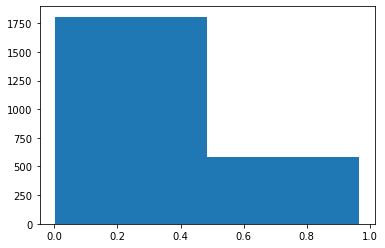

In [25]:
import matplotlib.pyplot as plt
plt.hist(predictions_probas['Industry'], bins = 2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(predictions_probas['Type'], bins = 2)
plt.show()

In [ ]:
error_metric(y_valid,y_pred)

In [ ]:
predictions_probas